In [25]:
from smilesfeaturizer import generate_smiles_feature
import pandas as pd

# Load data
- The dataset should inherently include a column named "SMILES," and it must contain a single target column for prediction. If the column name containing the SMILES format is different, please assign the name of that column to the "smiles_col" argument.

In [26]:
df = pd.read_csv("./data/big_smiles.csv")[:1000]

In [27]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


# Scatter plot
- Using the original DataFrame as input, we visualize the distribution of numeric columns as scatter plots.

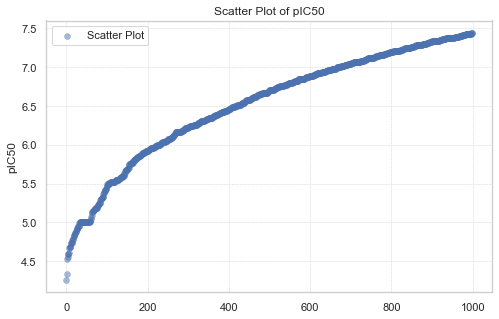

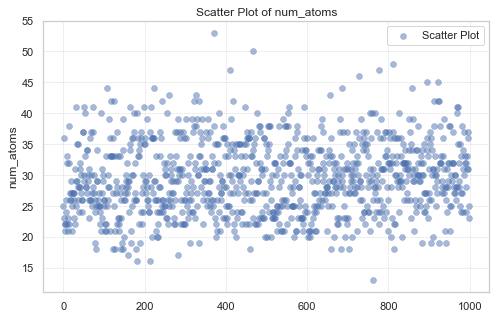

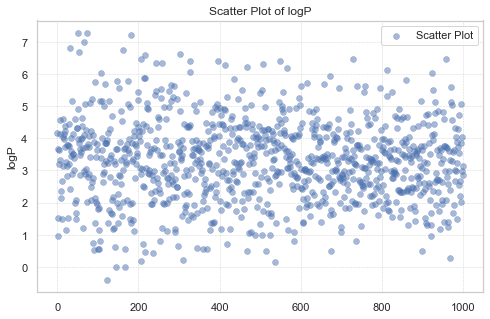

In [28]:
from smilesfeaturizer import df_scatter_plot

df_scatter_plot(df)

# Feature generation
- Create fingerprint columns for SMILES representations based on various packages like RDKit, Mol2Vec, DataMol, MolFeat, sklearn, etc.
- Generate various derived variables to enable ML expansion.
- By default, it uses the 'simple' method, but if you provide the 'specific' argument, it creates various functions based on MACCS, FPVec, ECFP, and RDKit 2D descriptors, represented with suffixes like 'ecfp_'.
- You can vectorize the given SMILES string based on various derived variables, and they are created as columns with one-hot encoding for ML suitability.

In [29]:
df = df[:100]
print(len(df.columns))

5


In [30]:
df = generate_smiles_feature(df) # default method="simple"
print(len(df.columns))

299


In [31]:
df = generate_smiles_feature(df, method="specific")
print(len(df.columns))

[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing Normalizer
[18:17:53] Running Normalizer
[18:17:53] WARNING: not removing hydrogen atom without neighbors
[18:17:53] Initializing N

2703


c:\Users\parkm\Desktop\BIG_SMILES\smilesfeaturizer\core.py:135: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Correlation heatmap
- Using derived variables generated based on the SMILES notation, we compare three correlation scores and visualize the top 10 highly correlated features.
- Similar to methodologies for calculating ELI5, SHAP values, or feature importance, this approach allows for a quick and straightforward assessment of multicollinearity and correlation from a data perspective.

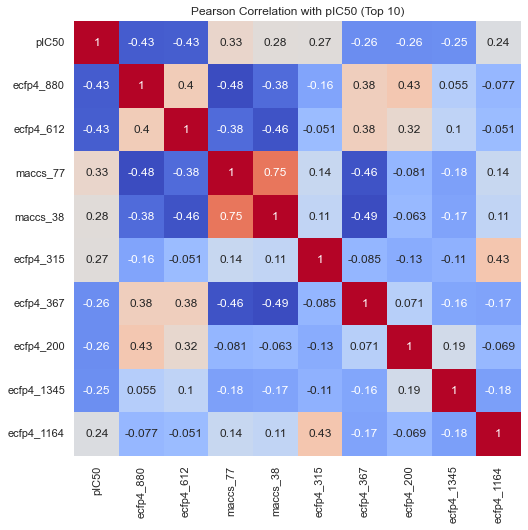

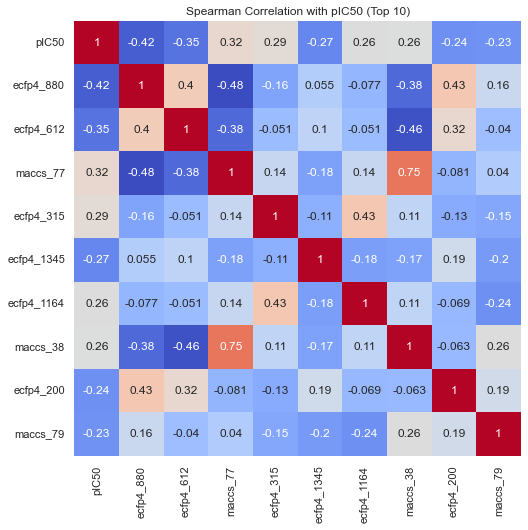

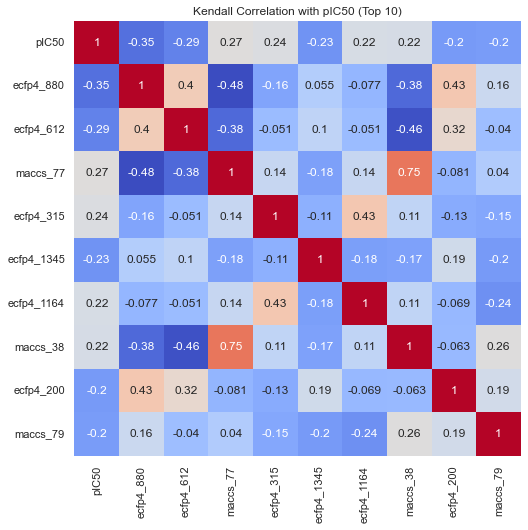

In [32]:
from smilesfeaturizer import draw_corr

draw_corr(df, "pIC50")

# Train machine learning model
- The utility of this package lies in providing fingerprints of SMILES strings with various derived variables, assisting in insights into researchers' datasets. 
- Therefore, it primarily examines very simple LGBM models. This process serves as a way to check for limitations, given that many tasks are insufficient and have discrete outcomes and data. 
- It can also be used as a supplementary tool for reviewing dashboards later.

The target column consists of continuous values, so we should use a regressor.
MSE on test set: 0.08


c:\Users\parkm\Desktop\BIG_SMILES\smilesfeaturizer\model\lgbm_model.py:109: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



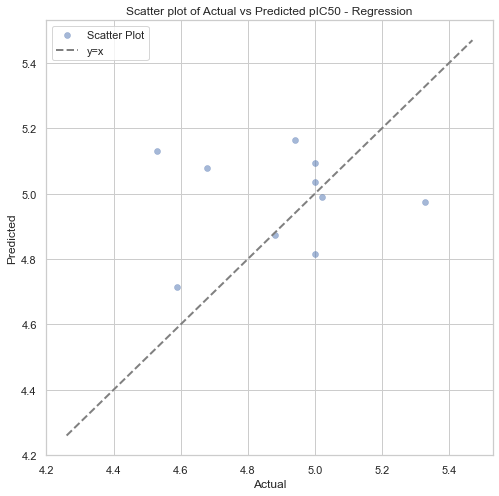

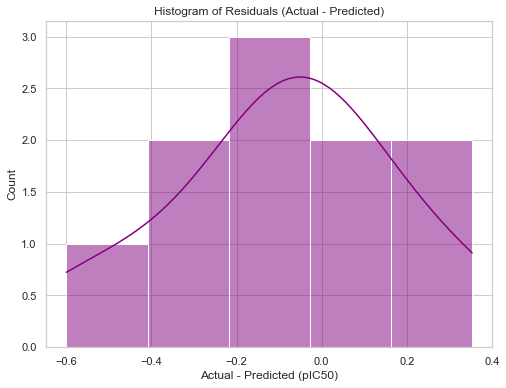

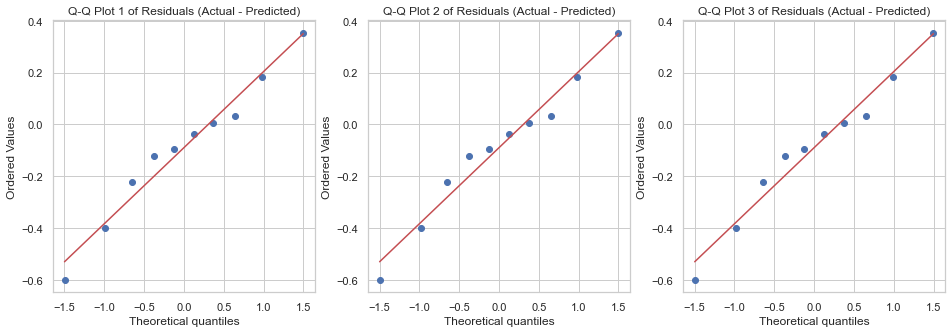

In [33]:
from smilesfeaturizer import train_lgbm

model, x_columns = train_lgbm(df, "pIC50")

In [34]:
df['predicted_pIC50'] = model.predict(df[x_columns])

# Create Dashboard 
- Through the dashboard, you can determine which compounds exhibit what prediction performance. 
- Researchers with domain knowledge can assess the prediction performance for specific molecules, identifying both good and poor performers, which can guide further modeling research.

In [35]:
from smilesfeaturizer import create_inline_dash_dashboard

# Load your DataFrame and specify the columns
true_col = 'pIC50'
predicted_col = 'predicted_pIC50'

# Create and run the Dash dashboard
create_inline_dash_dashboard(df, true_col, predicted_col)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

def smiles_insight_plot(df: pd.DataFrame, true_col: str, predicted_col: str, metric: str, folder: str, idx_start: int = 1, show: bool = False):
    """
    Generate and save analysis plots for SMILES data.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the SMILES data and additional information.
        true_col (str): The column name for the true values.
        predicted_col (str): The column name for the predicted values.
        metric (str): The metric to display in the plots. Options are 'RMSE' (Root Mean Squared Error),
            'MAE' (Mean Absolute Error), and 'R2' (R-squared).
        folder (str): The folder where the analysis plots will be saved.
        idx_start (int, optional): The starting index for numbering saved plots (default is 1).
        show (bool, optional): If True, display the plot for each iteration (default is False).

    Example usage:
        selected_metric = 'RMSE'  # Choose the error metric you want to display
        true_column = 'pIC50'  # Replace with your true column name
        predicted_column = 'predicted_pIC50'  # Replace with your predicted column name
        save_smiles_analysis_plot(df[:1], true_column, predicted_column, 'output_folder', selected_metric)
    """
    os.makedirs(folder, exist_ok=True)
    for idx, (index, row) in enumerate(df.iterrows(), start=idx_start):
        fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=300)

        # SMILES and molecular formula as title
        smiles = row.get('SMILES', 'Unknown')
        molecule = Chem.MolFromSmiles(smiles)
        formula = rdMolDescriptors.CalcMolFormula(molecule)
        axs[1].set_title(f"Molecule: {formula}\nSMILES: {smiles}")

        # Subplot for additional_info
        additional_info = row['dm_descriptor_dict']
        info_text = '\n'.join([f"{key}: {value:.2f}" for key, value in additional_info.items()])
        axs[0].text(0.1, 0.5, info_text, fontsize=12, verticalalignment='center', horizontalalignment='left')
        axs[0].axis('off')

        # Subplot for the image_array
        axs[1].imshow(row['image_array'])
        axs[1].axis('off')

        # Calculate the selected error metric
        error = calculate_error([row[true_col]], [row[predicted_col]], metric)

        # Bar plot for the selected metric on the right
        metric_names = [f'True {metric}', f'Predicted {metric}']
        metric_errors = [row[true_col], row[predicted_col]]
        axs[2].bar(metric_names, metric_errors, color=['blue', 'red'])
        axs[2].text(0, row[true_col] * 1.05, f"True {metric}: {row[true_col]:.2f}", color='blue', fontsize=14)
        axs[2].text(1, row[predicted_col] * 1.05, f"Predicted {metric}: {row[predicted_col]:.2f}", color='red', fontsize=14)
        axs[2].text(0.5, max(row[true_col], row[predicted_col]) * 0.8, f"{metric} Error: {error:.2f}", color='black', fontsize=14)
        axs[2].set_ylabel('Error')
        axs[2].set_title(f'{predicted_col} {metric} Error')

        # Save the figure
        plt.tight_layout()
        plt.savefig(f"{folder}/{idx}.jpg", dpi=300, bbox_inches='tight', pad_inches=0.1 )
        # Show the plot if 'show' is True
        if show:
            plt.show()
        plt.clf()

# Save reporting images

In [3]:
from smilesfeaturizer import smiles_insight_plot
# Example usage
selected_metric = 'RMSE'  # Choose the error metric you want to display
true_column = 'pIC50'  # Replace with your true column name
predicted_column = 'predicted_pIC50'  # Replace with your predicted column name
smiles_insight_plot(df[:1], true_column, predicted_column, selected_metric, 'output_folder', show=True)
